In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [23]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(autoload_with=engine)


In [6]:
# view all of the classes that automap found

print(Base.classes.keys())


['station', 'measurement']


In [7]:
# save the references to each table

station = Base.classes.station
measurement = Base.classes.measurement


In [8]:
# create session from Python to the database

from sqlalchemy.orm import sessionmaker

# bind the sessionmaker to the database engine

Session = sessionmaker(bind=engine)

# instantiate a session

session = Session()


# Exploratory Precipitation Analysis

In [21]:
# find the most recent date in the data set

most_recent_date_result = session.query(func.max(measurement.date)).one()

print("Most recent date:", most_recent_date_result)



Most recent date: ('2017-08-23',)


In [10]:
# extract the date from the tuple

most_recent_date = most_recent_date_result[0]


In [11]:
# convert date string to a datetime object
if isinstance(most_recent_date, str):
    most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')


In [12]:
# calculate one year ago

one_year_ago = most_recent_date - dt.timedelta(days=365)


<Figure size 1000x600 with 0 Axes>

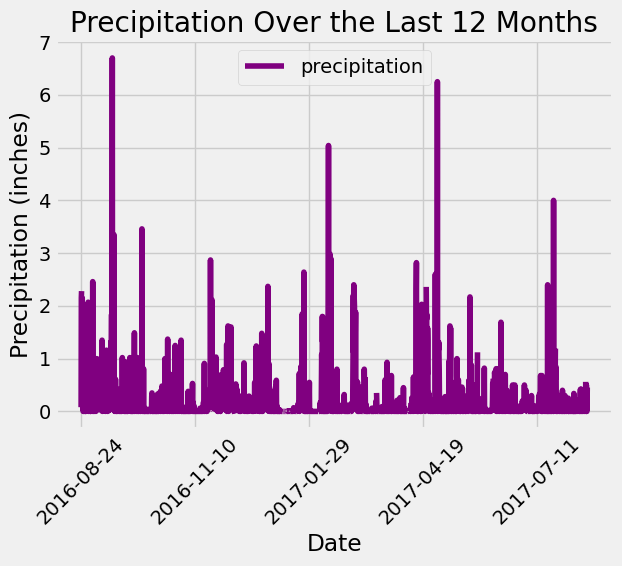

In [13]:
# query to retrieve the data and precipitation scores for the past year

precipitation_data = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= one_year_ago).\
    order_by(measurement.date).all()

# save query results as a Pandas dataframe with column names defined

df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# sort the dataframe by date

df.set_index('date', inplace=True)
df.sort_index(inplace=True)



# plot the data with pandas and myplotlib

plt.figure(figsize=(10, 6))
df.plot(rot=45, color='purple') 
plt.title("Precipitation Over the Last 12 Months")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.show()



In [26]:
# summary statistics for the precipitation data

summary_statistics = df['precipitation'].describe()

print("Summary Statistics for Precipitation Data:")
print(summary_statistics.to_string())



Summary Statistics for Precipitation Data:
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [15]:
# query to calculate the total number of stations in the dataset

total_stations = session.query(func.count(station.station)).scalar()
print("Total number of stations:", total_stations)


Total number of stations: 9


In [16]:
# query to find and list the most active stations in descending order

most_active_stations = session.query(
    measurement.station, 
    func.count(measurement.station)
).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()

for station, count in most_active_stations:
    print(f"Station {station} has {count} observations")


Station USC00519281 has 2772 observations
Station USC00519397 has 2724 observations
Station USC00513117 has 2709 observations
Station USC00519523 has 2669 observations
Station USC00516128 has 2612 observations
Station USC00514830 has 2202 observations
Station USC00511918 has 1979 observations
Station USC00517948 has 1372 observations
Station USC00518838 has 511 observations


In [17]:
# query to find the lowest, highest, and average temperature for most active station

most_active_station_id = most_active_stations[0][0]

temperature_stats = session.query(
    func.min(measurement.tobs),
    func.max(measurement.tobs),
    func.avg(measurement.tobs)
).filter(measurement.station == most_active_station_id).all()

# extract the temperature observations from the query results

min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Lowest Temperature for Station {most_active_station_id}: {min_temp:.2f}")
print(f"Highest Temperature for Station {most_active_station_id}: {max_temp:.2f}")
print(f"Average Temperature for Station {most_active_station_id}: {avg_temp:.2f}")


Lowest Temperature for Station USC00519281: 54.00
Highest Temperature for Station USC00519281: 85.00
Average Temperature for Station USC00519281: 71.66


In [18]:
# query the last 12 months of temperature observation data for most active station

temperature_data = session.query(measurement.tobs).\
    filter(measurement.station == most_active_station_id).\
    filter(measurement.date >= one_year_ago).all()

# extract the temperature observations from the query results

temperatures = [temp[0] for temp in temperature_data]


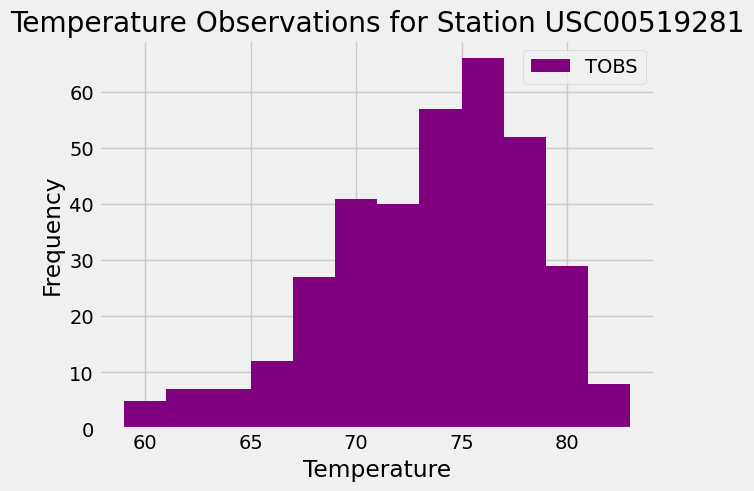

In [19]:
# plot as a histogram with `bins=12`

plt.hist(temperatures, bins=12, label='TOBS', color='purple')
plt.title(f"Temperature Observations for Station {most_active_station_id}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Close Session

In [20]:
# Close Session
session.close()